# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import librosa as lb
import IPython.display as ipd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# READ THE DATA

In [2]:
metadata = pd.read_csv('./m_metadata.csv')
print(f'Samples num: {metadata.shape[0]}\nColumns num: {metadata.shape[1]}')
metadata.head()

Samples num: 216
Columns num: 3


,Sample,Class_ID,Class
0,./input/notes_v2/A/A1.wav,1,A
1,./input/notes_v2/A/A1.wav_000.wav,1,A
2,./input/notes_v2/A/A1.wav_010.wav,1,A
3,./input/notes_v2/A/A2.wav,1,A
4,./input/notes_v2/A/A2.wav_001.wav,1,A


# GETTING DATA ABOUT CLASSES

In [4]:
classes = metadata.groupby('Class_ID')['Class'].unique()
classes

Class_ID
1           [A]
2           [B]
3           [C]
4           [D]
5           [E]
6           [F]
7           [G]
8      [Barrel]
9       [Flage]
10    [PoffHon]
11       [Slap]
12      [Slide]
Name: Class, dtype: object

# CREATING A FUNCTION TO EXTRACT DATA FROM SAMPLES

In [5]:
def feature_exctractor(path: str) -> np.array:
    data, _ = lb.load(path)
    data = lb.feature.mfcc(data, n_mfcc=128)
    data= np.mean(data, axis=1)

    return data

# DATA EXTRACTION

In [6]:
x, y = [], []

for i, rows in tqdm(metadata.iterrows()):
    path = rows['Sample']
    x.append(feature_exctractor(path))
    y.append(rows['Class_ID'])

x = np.array(x)
y = np.array(y)

x.shape, y.shape

216it [00:33,  6.38it/s]


((216, 128), (216,))

# TRANSFER OF TARGET CLASSES TO CATEGORIAL TYPE

In [7]:
y = to_categorical(y)
y.shape

(216, 13)

# SPLITTING INTO TRAINING / TEST / VALIDATION DATA

In [8]:
xtrainval, xtest, ytrainval, ytest = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrainval, ytrainval, test_size=0.2, stratify=ytrainval,random_state=42)

print('\nNumber of samples for Train set :',xtrain.shape[0])
print('Number of samples for Validation set :',xvalid.shape[0])
print('Number of samples for Test set :',xtest.shape[0])


Number of samples for Train set : 155
Number of samples for Validation set : 39
Number of samples for Test set : 22


# MODEL ARCHITECTURE

In [9]:
model = Sequential(
    [
        layers.Dense(1000, activation='relu', input_shape=(128,)),
        layers.Dense(750, activation='relu'),
        layers.Dense(500, activation='relu'),
        layers.Dense(250, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(13, activation='softmax')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              129000    
_________________________________________________________________
dense_1 (Dense)              (None, 750)               750750    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               375500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 13)                6

# MODEL COMPILATION AND TRAINING

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
training = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=20)

Epoch 1/20
5/5 [==============================] - 1s 61ms/step - loss: 15.3511 - accuracy: 0.1226 - val_loss: 10.7357 - val_accuracy: 0.1026
Epoch 2/20
5/5 [==============================] - 0s 23ms/step - loss: 6.3558 - accuracy: 0.1290 - val_loss: 3.5625 - val_accuracy: 0.1795
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 3.5869 - accuracy: 0.1161 - val_loss: 3.2486 - val_accuracy: 0.1538
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 3.0175 - accuracy: 0.1806 - val_loss: 2.4376 - val_accuracy: 0.2308
Epoch 5/20
5/5 [==============================] - 0s 23ms/step - loss: 2.3581 - accuracy: 0.2000 - val_loss: 2.3518 - val_accuracy: 0.1538
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 2.0867 - accuracy: 0.2516 - val_loss: 2.1483 - val_accuracy: 0.2308
Epoch 7/20
5/5 [==============================] - 0s 21ms/step - loss: 1.9199 - accuracy: 0.3548 - val_loss: 1.9304 - val_accuracy: 0.3590
Epoch 8/20
5/5 [=========

# VERIFICATION OF THE MODEL RESULTS

In [11]:
train_hist = pd.DataFrame(training.history)
train_hist

,loss,accuracy,val_loss,val_accuracy
0,15.351093,0.122581,10.735681,0.102564
1,6.355837,0.129032,3.562516,0.179487
2,3.586879,0.116129,3.248601,0.153846
3,3.017514,0.180645,2.437642,0.230769
4,2.358089,0.200000,2.351807,0.153846
5,2.086742,0.251613,2.148332,0.230769
6,1.919872,0.354839,1.930390,0.358974
7,1.664955,0.496774,1.696981,0.435897
8,1.426480,0.470968,1.522872,0.564103
9,1.236718,0.625806,1.425387,0.487179


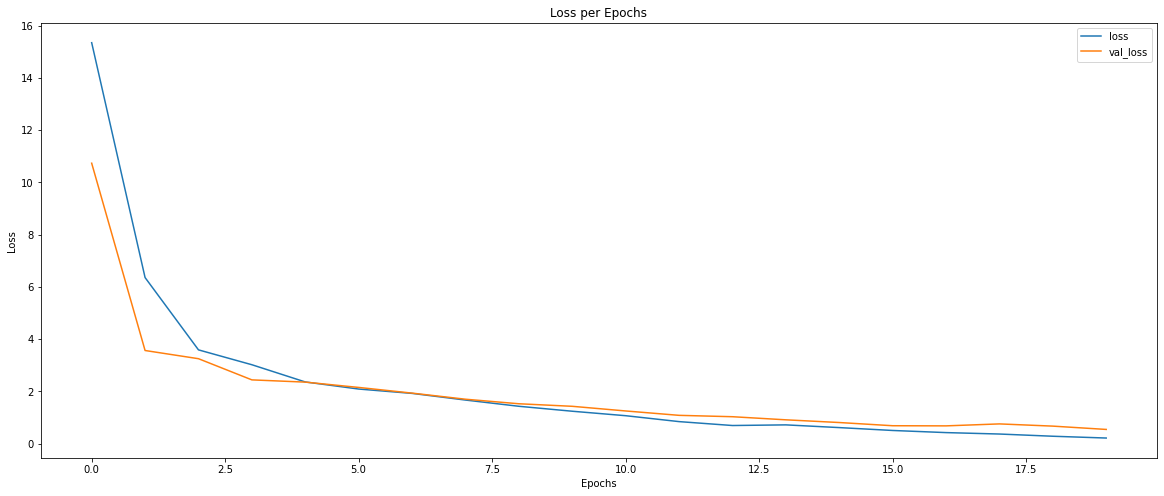

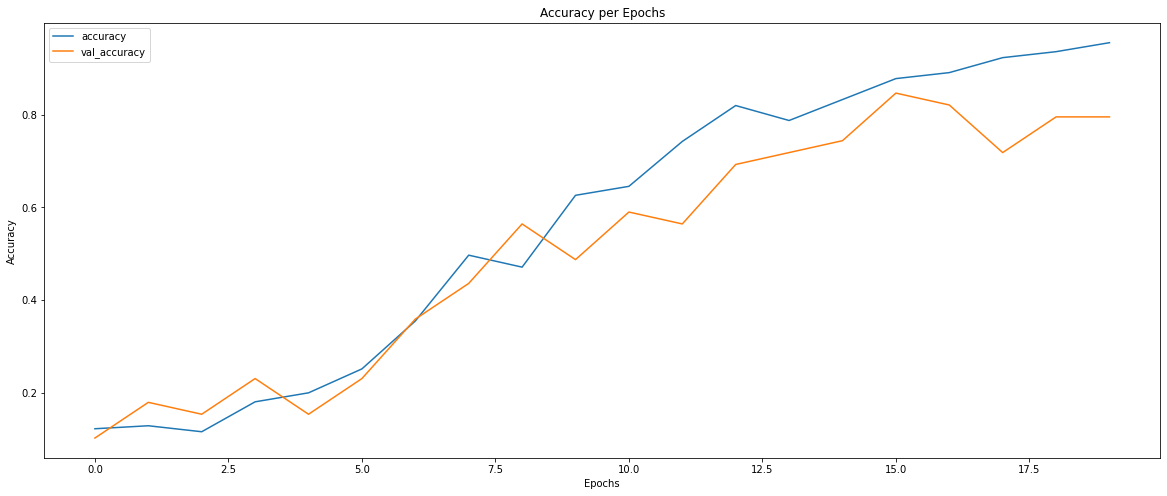

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(train_hist[['loss', 'val_loss']])
plt.legend(['loss', 'val_loss'])
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(train_hist[['accuracy', 'val_accuracy']])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [14]:
ytrue = np.argmax(ytest, axis=1)
ypred = np.argmax(model.predict(xtest), axis=1)
print('\nConfusion Matrix: \n\n')
print(confusion_matrix(ytrue, ypred))
print('\n\nClassification Report: \n\n', classification_report(ytrue, ypred))



Confusion Matrix: 


[[2 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]]


Classification Report: 

               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         2
          11       1.00      1